# CKP8366 - TÓPICOS AVANÇADOS - APRENDIZAGEM DE MÁQUINA PROBABILÍSTICA

<img  src="https://img.shields.io/badge/UFC_CKP8366-VAUX GOMES-000000?style=for-the-badge&logo=" /> <img src="https://img.shields.io/badge/Jupyter-000000?style=for-the-badge&logo=jupyter&logoColor=white" /> <img src="https://img.shields.io/badge/Python-000000?style=for-the-badge&logo=python&logoColor=white" />


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Gaussian Mixture Model)

In [ ]:
class GaussianMixtureModel:
  def __init__(self, k):
    self.k = k
    
  def fit(self, X, y):
    pass
  
  def predict(self, X):
    pass
  
  def __str__(self):
    return f'GaussianMixtureModel: \n(K → {self.k})'

#### Carregamento dos dados

In [15]:
# Data
data = np.genfromtxt('./files/clustering_data.csv', delimiter=',')
data.shape

(100, 2)

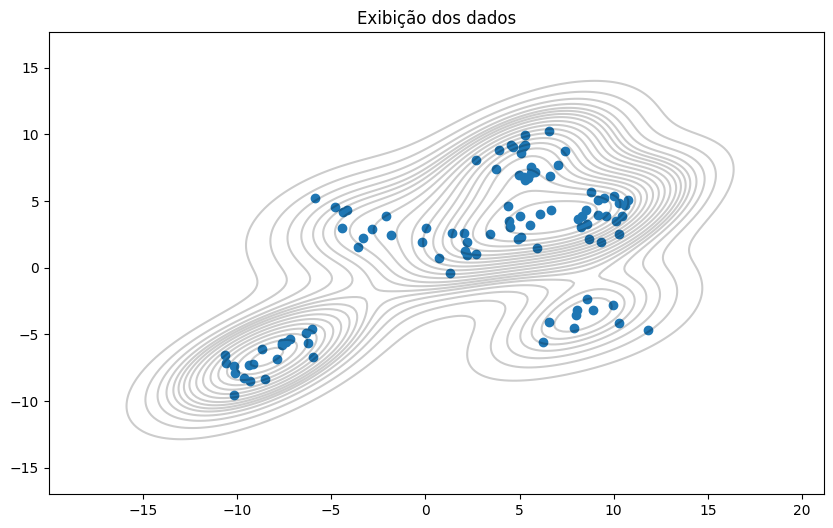

In [18]:
plt.figure(figsize=(10,6))

plt.scatter(data[:,0],data[:,1])
sns.kdeplot(x=data[:, 0], y=data[:, 1], levels=20, color='k', alpha=0.2)

plt.grid(False)
plt.title('Exibição dos dados')
plt.show()